In [0]:
# %cd mutla
import pandas as pd
import numpy as np

# Data importing, merging, and cleanup

This file builds upon the [MUTLA Data Cleaning notebook](https://colab.research.google.com/drive/1DqCZ4V8nptp9_2zsfq4wnq9Sk5iu7rdN?usp=sharing). Please check that for any inconsistencies. The .csv files generated from that notebook can be found in our S3 Bucket. See the links below to acces these dataframe CSVs.

In [0]:
# drop rows with no attention value 
csv_data = pd.read_csv('https://attention-difficulty.s3.us-east-2.amazonaws.com/mutla-final-data.csv',delimiter=',')
avg_data = pd.read_csv('https://attention-difficulty.s3.us-east-2.amazonaws.com/mutla-averaged-attention.csv')

joined = pd.merge(csv_data, avg_data)
joined['avg'] = joined['specific_attention'].isnull()
joined['specific_attention'] = joined.specific_attention.fillna(joined['avg_attention']) # fill specific attention with the avg_attention from the avg_data df
dropped = joined

Seems to be missing Chemistry and English Reading subjects. No attention files maybe?

In [0]:
csv_data.subject.value_counts()

en      1349
math    1234
phy      594
cn       235
Name: subject, dtype: int64

In [0]:
display(dropped.shape) 
display(dropped.head(10))

(3412, 16)

,Unnamed: 0,user_id,subject,question_id,school_id,is_right_x,stime,ctime,brainwave_file_path_attention,school_index,difficulty,is_right_y,s3_brainwave_file_path_attention,specific_attention,avg_attention,avg
0,0,6840100808795007,math,590bdec1f4aeb5737e1de73b,196,0,02-Dec-2018 14:50:24,02-Dec-2018 14:54:10,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
1,1,6840100808795007,math,590bdec1f4aeb5737e1de73a,196,0,02-Dec-2018 14:54:32,02-Dec-2018 14:58:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
2,2,6840100808795007,math,590bdec1f4aeb5737e1de74a,196,0,02-Dec-2018 14:58:27,02-Dec-2018 15:00:29,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
3,3,6840100808795007,math,590bdec1f4aeb5737e1de749,196,1,02-Dec-2018 15:00:29,02-Dec-2018 15:01:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
4,4,6840100808795007,math,590bdec1f4aeb5737e1de74b,196,0,02-Dec-2018 15:01:27,02-Dec-2018 15:03:28,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
5,5,6840100808795007,math,58ff1107f4aeb56d7372d1da,196,0,02-Dec-2018 15:03:29,02-Dec-2018 15:05:22,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
6,6,6840100808795007,math,58ff1107f4aeb56d7372d1db,196,0,02-Dec-2018 15:06:20,02-Dec-2018 15:12:24,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True
7,7,6840100808795007,math,590bdec1f4aeb5737e1de848,196,0,02-Dec-2018 15:12:24,02-Dec-2018 15:14:11,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,39.533333,38.327044,False
8,8,6840100808795007,math,590bdec1f4aeb5737e1de849,196,1,02-Dec-2018 15:14:12,02-Dec-2018 15:14:56,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,50.297297,38.327044,False
9,9,6840100808795007,math,590bdec1f4aeb5737e1de84a,196,1,02-Dec-2018 15:14:57,02-Dec-2018 15:16:37,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,31.520000,38.327044,False


In [0]:
# modify data 
dropped['ctime'] = pd.to_datetime(dropped['ctime'])
dropped['stime'] = pd.to_datetime(dropped['stime'])
dropped['time_spent'] = (dropped['ctime'] - dropped['stime']).astype('timedelta64[s]')
dropped.head()

,Unnamed: 0,user_id,subject,question_id,school_id,is_right_x,stime,ctime,brainwave_file_path_attention,school_index,difficulty,is_right_y,s3_brainwave_file_path_attention,specific_attention,avg_attention,avg,time_spent
0,0,6840100808795007,math,590bdec1f4aeb5737e1de73b,196,0,2018-12-02 14:50:24,2018-12-02 14:54:10,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,226.0
1,1,6840100808795007,math,590bdec1f4aeb5737e1de73a,196,0,2018-12-02 14:54:32,2018-12-02 14:58:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,234.0
2,2,6840100808795007,math,590bdec1f4aeb5737e1de74a,196,0,2018-12-02 14:58:27,2018-12-02 15:00:29,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,122.0
3,3,6840100808795007,math,590bdec1f4aeb5737e1de749,196,1,2018-12-02 15:00:29,2018-12-02 15:01:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,57.0
4,4,6840100808795007,math,590bdec1f4aeb5737e1de74b,196,0,2018-12-02 15:01:27,2018-12-02 15:03:28,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,121.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


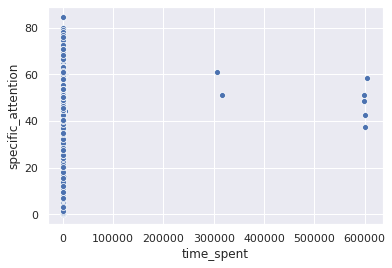

In [0]:
# analysis
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x='time_spent', y='specific_attention', data=dropped)
plt.show()

In [0]:
# further cleanup 
dropped = dropped[(dropped['time_spent'] < 10000)]
dropped = dropped[(dropped['specific_attention'] != 0)]

In [0]:
time_spent = dropped.copy()
time_spent['logged'] = np.log10(dropped['time_spent'])
t_v_d = time_spent[['logged', 'difficulty', 'specific_attention']]
t_v_d.head()

,logged,difficulty,specific_attention
0,2.354108,2,38.327044
1,2.369216,2,38.327044
2,2.086360,2,38.327044
3,1.755875,2,38.327044
4,2.082785,2,38.327044


In [0]:
tvd_grouped = t_v_d.groupby('difficulty').agg(list)
tvd_grouped

,logged,specific_attention
difficulty,,
1,"[1.5185139398778875, 2.2648178230095364, 1.079...","[52.24242424242424, 54.84239130434783, 50.8333..."
2,"[2.3541084391474008, 2.369215857410143, 2.0863...","[38.32704402515724, 38.32704402515724, 38.3270..."
3,"[1.2787536009528289, 1.4313637641589874, 1.361...","[51.66239027683997, 51.66239027683997, 51.6623..."
4,"[1.4771212547196624, 1.6334684555795866, 0.698...","[46.6, 46.930232558139544, 45.56345494231369, ..."
5,"[1.2041199826559248, 1.3617278360175928, 1.505...","[37.834754098360655, 37.834754098360655, 61.34..."
6,"[1.806179973983887, 1.6812412373755872, 1.3979...","[36.28125, 47.4375, 50.28, 55.5, 61.6428571428..."
7,"[2.3096301674258988, 1.99563519459755, 2.06818...","[56.941176470588225, 58.36363636363637, 50.072..."
8,"[1.9637878273455553, 1.3424226808222062, 1.544...","[37.834754098360655, 37.834754098360655, 49.97..."
9,"[3.2727695865517594, 3.042181594515766, 2.4653...","[59.52186588921282, 51.63214670981661, 46.9876..."


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


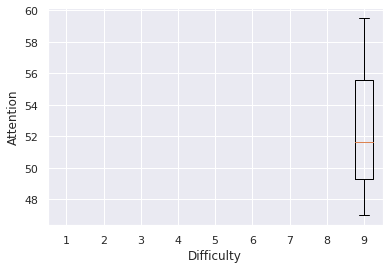

In [0]:
dictionary = dict(zip(tvd_grouped.index, tvd_grouped['specific_attention'].values))
fig, ax = plt.subplots();
ax.boxplot(dictionary.values());
ax.set_xticklabels(dictionary.keys());
plt.xlabel('Difficulty');
plt.ylabel('Attention');

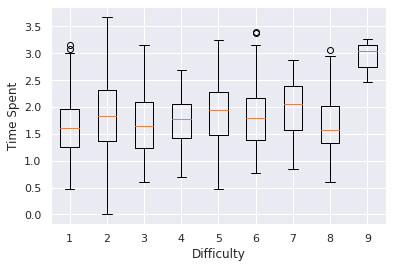

In [0]:
dictionary = dict(zip(tvd_grouped.index, tvd_grouped['logged'].values))
fig, ax = plt.subplots();
ax.boxplot(dictionary.values());
ax.set_xticklabels(dictionary.keys());
plt.xlabel('Difficulty');
plt.ylabel('Time Spent');

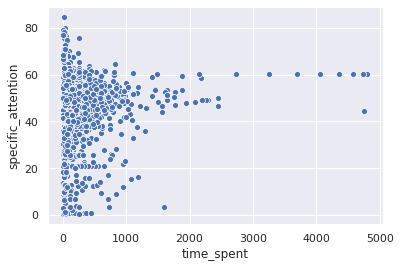

In [0]:
ax = sns.scatterplot(x='time_spent', y='specific_attention', data=dropped)
plt.show()

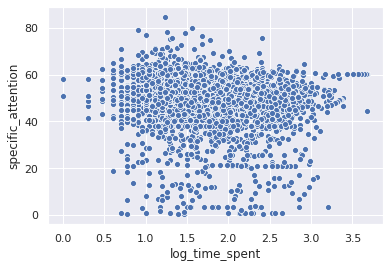

In [0]:
dropped['log_time_spent'] = np.log10(dropped['time_spent'])
ax = sns.scatterplot(x='log_time_spent', y='specific_attention', data=dropped)


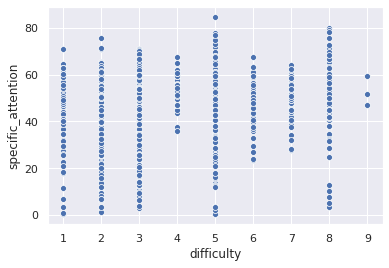

In [0]:
ax = sns.scatterplot(x='difficulty', y='specific_attention', data=dropped)
plt.show()

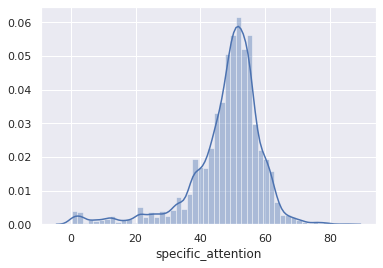

In [0]:
sns.distplot(dropped['specific_attention'])

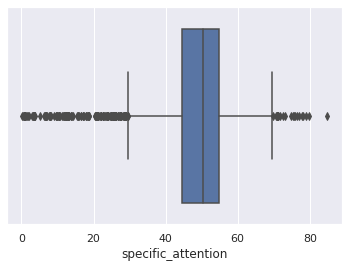

In [0]:
sns.boxplot(dropped['specific_attention'])

In [0]:
dropped['specific_attention'].std()

11.237092315028672

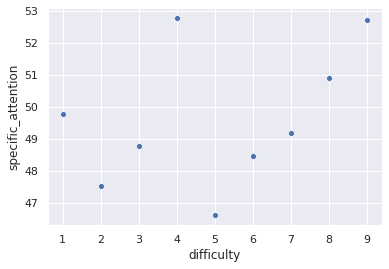

In [0]:
diff_grouped = dropped.groupby('difficulty').mean().reset_index()
ax = sns.scatterplot(x='difficulty', y='specific_attention', data=diff_grouped)
plt.show()

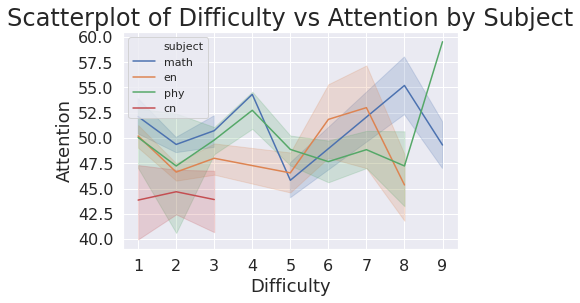

In [0]:
# shows above plot in a bin scattered lineplot based on subject 
grouped = dropped.groupby(['subject', 'difficulty']).mean().reset_index()
ax = sns.lineplot(x='difficulty', y='specific_attention', data=dropped, hue='subject', );
plt.xticks(size=16);
plt.yticks(size=16);
plt.xlabel('Difficulty', size=18);
plt.ylabel('Attention', size=18);
ax.set_title('Scatterplot of Difficulty vs Attention by Subject', size=24);

In [0]:
# split into X and Y 
print(dropped.shape)
print(dropped.dropna().shape)

dropped.dropna(inplace=True)
data = dropped[['subject', 'stime', 'ctime', 'difficulty', 'time_spent', 'is_right_x', 'log_time_spent']]
target = dropped['specific_attention']

print(data.shape)
print(data.dropna().shape)
print(target.shape)
print(target.dropna().shape)

(3280, 18)
(3188, 18)
(3188, 7)
(3188, 7)
(3188,)
(3188,)


In [0]:
from sklearn.preprocessing import LabelEncoder

encoded_data = data[['subject', 'log_time_spent', 'is_right_x', 'difficulty']]
encoded_data = encoded_data.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(encoded_data.select_dtypes(include=['number']))
encoded_data.head()

,subject,log_time_spent,is_right_x,difficulty
0,2,2.354108,0,2
1,2,2.369216,0,2
2,2,2.086360,0,2
3,2,1.755875,1,2
4,2,2.082785,0,2


In [0]:
print(encoded_data.shape)
print(encoded_data.dropna().shape)

(3188, 4)
(3188, 4)


# Modeling using an SVM

Can we predict attention from question features? What is the correlation between features in the MUTLA question data and the question-specific attention readings retrieved from the brainwave scans?

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

x_train, x_test, y_train, y_test = train_test_split(encoded_data, target, test_size=0.1)
model = SVR() # TODO: play with parameters 

In [0]:
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)
print(score)

-0.03516199123771924


Getting a low R^2 score (~0) indicates that the features used (such as Difficulty, Time Spent, etc.) have no stronger a correlation to the target (Question-Specific Attention) than a horizontal line. This could be due to (a) invalid hypothesis that difficulty and attention are related, (b) data noise -- a known issue with brainwave data, (c) variability among students wearing the devices and the different sequences of completed questions.

In [0]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(predictions, y_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.735


In [0]:
x_train.head()

,subject,log_time_spent,is_right_x,difficulty
1384,2,1.991226,1,5
380,3,2.745855,1,5
3333,0,2.394452,0,3
3324,0,2.025306,0,3
3079,1,1.146128,0,2


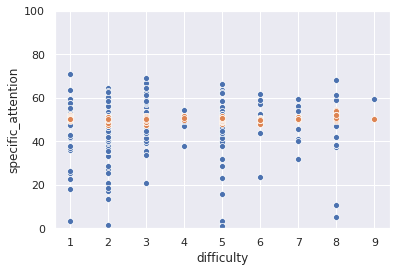

In [0]:
sns.scatterplot(x=x_test['difficulty'], y=y_test)
sns.scatterplot(x=x_test['difficulty'], y=predictions)
plt.ylim(0,100)
plt.show()

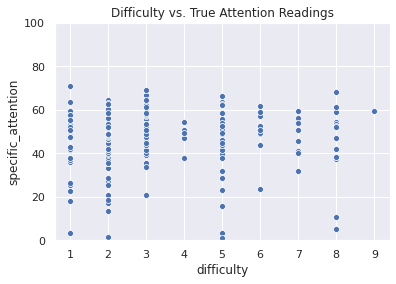

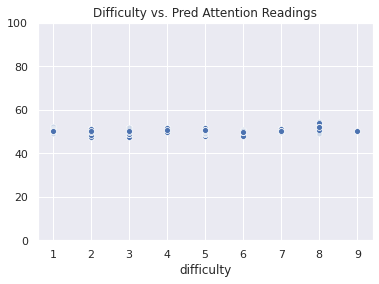

In [0]:
sns.scatterplot(x=x_test['difficulty'], y=y_test)
plt.title('Difficulty vs. True Attention Readings')
plt.ylim(0,100)
plt.show()
sns.scatterplot(x=x_test['difficulty'], y=predictions)
plt.title('Difficulty vs. Pred Attention Readings')
plt.ylim(0,100)
plt.show()

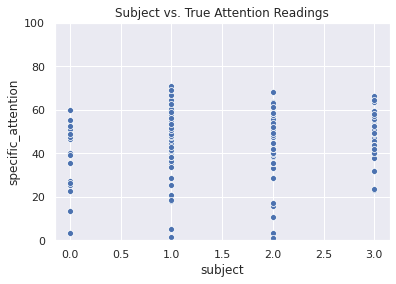

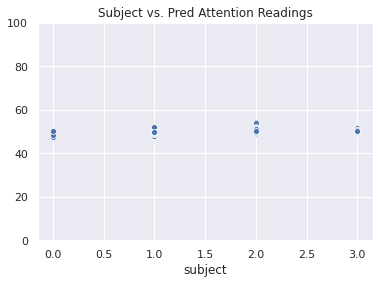

In [0]:
sns.scatterplot(x=x_test['subject'], y=y_test)
plt.title('Subject vs. True Attention Readings')
plt.ylim(0,100)
plt.show()
sns.scatterplot(x=x_test['subject'], y=predictions)
plt.title('Subject vs. Pred Attention Readings')
plt.ylim(0,100)
plt.show()

# Sequence prediction task

Let's see if we can better model attention from students' questions and responses using a recurrent network.

1. Determine if questions were asked in a specific sequence
2. If so, find the longest subsequence of questions common to all students. If not find out the longest, most common subsequences of questions. If none exist (i.e. questions appear to be randomized and/or matched sequences are quite short), match sequences more broadly on difficulty sequences.
3. Make an array of dim [#students, #questions, #features] to feed to the RNN 
4. Use RNN to predict each student's expected attention based on the features and the question history so far

Note: For the RNN, since it appears that there weren't any sequences of questions that all (or even more than 7) students had to do, I decided to model on difficulty sequences instead -- the questions in any sequence are in done in chronological order by the same student but they may be from different subjects, have large gaps of time between problems, etc. Additionally, to simplify the problem, I restricted the sequence length to 10. This number is long enough, easy to work with, and there also happen to be a variety of length-10 difficulty sequences that are common throughout the data. Therefore our model now predicts attention score from sequential (but possibly mixed) length-10 response data using features like difficulty, response correctness, subject, and time_spent but disregards matching question sequences by subject, actual question text, or sitting time.

In [0]:
import pandas as pd
import numpy as np
csv_data = pd.read_csv('https://attention-difficulty.s3.us-east-2.amazonaws.com/mutla-final-data.csv',delimiter=',')
avg_data = pd.read_csv('https://attention-difficulty.s3.us-east-2.amazonaws.com/mutla-averaged-attention.csv')

In [0]:
df = pd.merge(csv_data, avg_data)
df['avg'] = df['specific_attention'].isnull()
df['specific_attention'] = df.specific_attention.fillna(df['avg_attention']) # fill specific attention with the avg_attention from the avg_data df
df['ctime'] = pd.to_datetime(df['ctime'])
df['stime'] = pd.to_datetime(df['stime'])
df['time_spent'] = (df['ctime'] - df['stime']).astype('timedelta64[s]')
print(len(df) - df.count())
df.dropna(inplace=True)
df.head()

Unnamed: 0                           0
user_id                              0
subject                              0
question_id                          0
school_id                            0
is_right_x                           0
stime                                0
ctime                                0
brainwave_file_path_attention        0
school_index                         0
difficulty                           0
is_right_y                           0
s3_brainwave_file_path_attention     0
specific_attention                  92
avg_attention                       92
avg                                  0
time_spent                           0
dtype: int64


,Unnamed: 0,user_id,subject,question_id,school_id,is_right_x,stime,ctime,brainwave_file_path_attention,school_index,difficulty,is_right_y,s3_brainwave_file_path_attention,specific_attention,avg_attention,avg,time_spent
0,0,6840100808795007,math,590bdec1f4aeb5737e1de73b,196,0,2018-12-02 14:50:24,2018-12-02 14:54:10,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,226.0
1,1,6840100808795007,math,590bdec1f4aeb5737e1de73a,196,0,2018-12-02 14:54:32,2018-12-02 14:58:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,234.0
2,2,6840100808795007,math,590bdec1f4aeb5737e1de74a,196,0,2018-12-02 14:58:27,2018-12-02 15:00:29,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,122.0
3,3,6840100808795007,math,590bdec1f4aeb5737e1de749,196,1,2018-12-02 15:00:29,2018-12-02 15:01:26,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,57.0
4,4,6840100808795007,math,590bdec1f4aeb5737e1de74b,196,0,2018-12-02 15:01:27,2018-12-02 15:03:28,schoolg/20181202-14-39/attention_f0fe6b76a13a.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,38.327044,38.327044,True,121.0


In [0]:
df.sort_values(['user_id', 'subject', 'question_id']).head()

,Unnamed: 0,user_id,subject,question_id,school_id,is_right_x,stime,ctime,brainwave_file_path_attention,school_index,difficulty,is_right_y,s3_brainwave_file_path_attention,specific_attention,avg_attention,avg,time_spent
3202,3202,44749,cn,31647,290,0,2018-12-01 08:22:19,2018-12-01 08:25:03,schooln/20181201-15-59/attention_f0fe6b55e1d2.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,46.424438,46.424438,True,164.0
3199,3199,44749,cn,31648,290,1,2018-12-01 08:13:25,2018-12-01 08:17:58,schooln/20181201-15-59/attention_f0fe6b55e1d2.log,1,2,1,https://attention-difficulty.s3.us-east-2.amaz...,46.424438,46.424438,True,273.0
3201,3201,44749,cn,31649,290,0,2018-12-01 08:17:58,2018-12-01 08:22:18,schooln/20181201-15-59/attention_f0fe6b55e1d2.log,1,3,0,https://attention-difficulty.s3.us-east-2.amaz...,46.424438,46.424438,True,260.0
3206,3206,44749,cn,31653,290,0,2018-12-01 08:46:26,2018-12-01 08:59:09,schooln/20181201-15-59/attention_f0fe6b55e1d2.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,46.424438,46.424438,True,763.0
3208,3208,44749,cn,31654,290,0,2018-12-01 08:59:15,2018-12-01 09:03:07,schooln/20181201-15-59/attention_f0fe6b55e1d2.log,1,2,0,https://attention-difficulty.s3.us-east-2.amaz...,46.424438,46.424438,True,232.0


## Sequence Analysis

(See note above)

In analyzing the different sequences of questions, we discovered that students answered questions in different orders. The longest common subsequence of questions was only 4 questions long and was common to 7 students. Seeing as this makes sequence prediction impossible, we switched over to finding the longest common sequences by question difficulty instead. This strategy will allow us to match based on the difficulties of the sequences rather than the questions themselves. 

Through this approach, we found that we could easily use length-10 sequences of questions, as there are many common 10-length difficulty sequences. Therefore, our model will use information like question difficulty, response correctness, time spent, and/or question subject to predict the attention scores corresponding to each question in the sequence.

In [0]:
from sklearn.preprocessing import LabelEncoder

stime_sort = df.sort_values(['user_id', 'stime'])
stime_sort = stime_sort.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(stime_sort.select_dtypes(include=['number']))
subset = stime_sort[['time_spent', 'specific_attention']]
stime_sort[['time_spent', 'specific_attention']] = (subset-subset.min())/(subset.max()-subset.min())
stime_sort = stime_sort[['subject', 'difficulty', 'specific_attention', 'user_id', 'is_right_x', 'time_spent']].astype('float32')
print(stime_sort.dtypes)
difficulty_sequences = {}
for uid in stime_sort.user_id.unique():
  per_user = stime_sort[(stime_sort['user_id']==uid)] # in chronological order by user (order/user is the only guarantee)
  difficulty_sequences[uid] = list(zip(per_user.difficulty.tolist(), per_user.subject.tolist(), per_user.is_right_x.tolist(), per_user.time_spent.tolist(), per_user.specific_attention.tolist()))

subject               float32
difficulty            float32
specific_attention    float32
user_id               float32
is_right_x            float32
time_spent            float32
dtype: object


Find sequences of questions not based on what specific questions got answered but only on the difficulty rating of the questions in the sequence. These sequences can be from across different sequences but are answered chronologically

In [0]:
stime_sort.groupby('user_id').size()

user_id
4.474900e+04      22
4.475000e+04      66
4.660500e+04      31
4.760100e+04      25
4.995600e+04      41
4.998800e+04      49
5.036900e+04      63
5.037200e+04       6
5.069800e+04      20
5.202700e+04      15
5.215100e+04      11
5.634200e+04      25
5.737900e+04      14
5.913400e+04      17
5.915200e+04      75
6.795600e+04      12
6.886800e+04      15
6.887000e+04      10
7.182300e+04      10
7.182400e+04      26
7.182700e+04      42
7.182800e+04      26
7.501300e+04      86
7.540400e+04      24
7.578300e+04      27
7.578400e+04      10
7.579700e+04       1
7.579800e+04       6
7.579900e+04      19
7.580200e+04      57
7.596100e+04      48
7.596200e+04      29
7.606700e+04       2
7.609000e+04      24
7.624100e+04      16
7.825400e+04       9
7.847200e+04      78
7.870200e+04      46
7.927600e+04      17
7.984100e+04       4
6.743483e+15      14
6.840101e+15    1526
6.860101e+15     128
6.880101e+15     528
dtype: int64

In [0]:
sequences = list(difficulty_sequences.values())
min_seq_length = 10
seen = {}
for seq in sequences:
  difficulty_seq = [i[0] for i in seq]
  for i in range(0, len(seq)-min_seq_length):
    j = min(i+min_seq_length, len(seq))
    # for j in range(min(i+min_seq_length, len(seq)), len(seq)):
    subsequence = tuple(difficulty_seq[i:j])
    if subsequence in seen:
      seen[subsequence].append(seq[i:j])
    else:
      seen[subsequence] = [seq[i:j]]

most_common = sorted(list(seen.values()), key=lambda x: len(x), reverse=True)

In [0]:
min_occurrences = 4 # train on difficulty sequences that are somewhat common
dataset = [i for i in most_common if len(i) > min_occurrences]
responses = []
for case in dataset:
  responses.extend(case)
responses = np.array(responses)
print(responses.shape)

(617, 10, 5)


In [0]:
# vector = ['difficulty', 'subject', 'is_right_x', 'time_spent', 'specific_attention']

X, y = responses[:, :, :-1], responses[:, :, -1]
print( "example sequence of input vectors corresponding to 10 responses by a particular student")
print(X[1])
print("example test output of the RNN model")
print(y[1])

example sequence of input vectors corresponding to 10 responses by a particular student
[[2.00000000e+00 2.00000000e+00 1.00000000e+00 9.41824983e-05]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 3.28812574e-04]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 7.27022780e-05]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 1.96626614e-04]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 9.25301720e-05]
 [2.00000000e+00 2.00000000e+00 0.00000000e+00 3.04027693e-04]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 1.35490613e-04]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 6.93976253e-05]
 [2.00000000e+00 2.00000000e+00 0.00000000e+00 5.61790330e-05]
 [2.00000000e+00 2.00000000e+00 1.00000000e+00 8.88950599e-04]]
example test output of the RNN model
[0.61081004 0.61081004 0.64012349 0.64496201 0.59152049 0.58486962
 0.69427907 0.61388886 0.48070747 0.61081004]


In [0]:
# 80% train test split
train_pct = 0.8 
msk = np.random.rand(len(X)) < train_pct 
X_train, X_test = X[msk], X[~msk]
y_train, y_test = y[msk], y[~msk]


val_pct = 0.8 
msk = np.random.rand(len(X_train)) < val_pct
X_train, X_val = X_train[msk], X_train[~msk]
y_train, y_val = y_train[msk], y_train[~msk]

In [0]:
X[np.argwhere(np.isnan(X))]

array([], shape=(0, 3, 10, 4), dtype=float64)

Train on 403 samples, validate on 90 samples
Epoch 1/75
 - 3s - loss: 0.1469 - val_loss: 0.1343
Epoch 2/75
 - 1s - loss: 0.1287 - val_loss: 0.1350
Epoch 3/75
 - 1s - loss: 0.1279 - val_loss: 0.1333
Epoch 4/75
 - 1s - loss: 0.1253 - val_loss: 0.1378
Epoch 5/75
 - 1s - loss: 0.1266 - val_loss: 0.1334
Epoch 6/75
 - 1s - loss: 0.1264 - val_loss: 0.1296
Epoch 7/75
 - 1s - loss: 0.1238 - val_loss: 0.1337
Epoch 8/75
 - 1s - loss: 0.1247 - val_loss: 0.1297
Epoch 9/75
 - 1s - loss: 0.1226 - val_loss: 0.1274
Epoch 10/75
 - 1s - loss: 0.1222 - val_loss: 0.1359
Epoch 11/75
 - 1s - loss: 0.1242 - val_loss: 0.1299
Epoch 12/75
 - 1s - loss: 0.1248 - val_loss: 0.1323
Epoch 13/75
 - 1s - loss: 0.1221 - val_loss: 0.1282
Epoch 14/75
 - 1s - loss: 0.1215 - val_loss: 0.1281
Epoch 15/75
 - 1s - loss: 0.1213 - val_loss: 0.1318
Epoch 16/75
 - 1s - loss: 0.1204 - val_loss: 0.1273
Epoch 17/75
 - 1s - loss: 0.1206 - val_loss: 0.1306
Epoch 18/75
 - 1s - loss: 0.1208 - val_loss: 0.1276
Epoch 19/75
 - 1s - loss: 0.

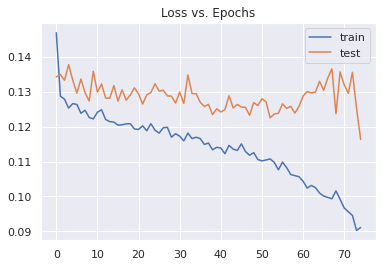

In [0]:
import keras
from keras import Sequential
from keras.regularizers import l1_l2, l2
from keras.layers import LSTM, Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[1], 
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
opt = Adam(lr=.005, clipnorm=.001)
model.compile(loss='mae', optimizer=opt)
# fit network
history = model.fit(X_train, y_train, epochs=75, batch_size=5, validation_data=(X_val, y_val), verbose=2, shuffle=True)
# plot history
plt.title('Loss vs. Epochs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

def revert_scaling(scale_df, name, vec):
  return vec * (scale_df[name].max() - scale_df[name].min()) + scale_df[name].min()

# calculate RMSE
yhat = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_test), revert_scaling(subset, 'specific_attention', yhat)))
print('Test RMSE: %.3f' % rmse)

yhat = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_val), revert_scaling(subset, 'specific_attention', yhat)))
print('Val RMSE: %.3f' % rmse)

yhat = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_train), revert_scaling(subset, 'specific_attention', yhat)))
print('Train RMSE: %.3f' % rmse)

Test RMSE: 15.403
Val RMSE: 15.658
Train RMSE: 12.563


## Trying out different difficulty sequences

In [0]:
# vector = ['difficulty', 'subject', 'is_right_x', 'time_spent', 'specific_attention']
X, y = responses[550:, :, :-1], responses[550:, :, -1]
print( "example sequence of input vectors corresponding to 10 responses by a particular student")
print(X.shape)
print("example test output of the RNN model")
print(y.shape)

example sequence of input vectors corresponding to 10 responses by a particular student
(67, 10, 4)
example test output of the RNN model
(67, 10)


In [0]:
# 80% train test split
train_pct = 0.8 
msk = np.random.rand(len(X)) < train_pct 
X_train, X_test = X[msk], X[~msk]
y_train, y_test = y[msk], y[~msk]


val_pct = 0.8 
msk = np.random.rand(len(X_train)) < val_pct
X_train, X_val = X_train[msk], X_train[~msk]
y_train, y_val = y_train[msk], y_train[~msk]

Train on 44 samples, validate on 10 samples
Epoch 1/75
 - 1s - loss: 0.2231 - val_loss: 0.1225
Epoch 2/75
 - 0s - loss: 0.1155 - val_loss: 0.1045
Epoch 3/75
 - 0s - loss: 0.1090 - val_loss: 0.1068
Epoch 4/75
 - 0s - loss: 0.1006 - val_loss: 0.0905
Epoch 5/75
 - 0s - loss: 0.0973 - val_loss: 0.0920
Epoch 6/75
 - 0s - loss: 0.0966 - val_loss: 0.0977
Epoch 7/75
 - 0s - loss: 0.0977 - val_loss: 0.0986
Epoch 8/75
 - 0s - loss: 0.0984 - val_loss: 0.0879
Epoch 9/75
 - 0s - loss: 0.0999 - val_loss: 0.0946
Epoch 10/75
 - 0s - loss: 0.0974 - val_loss: 0.0941
Epoch 11/75
 - 0s - loss: 0.1029 - val_loss: 0.0966
Epoch 12/75
 - 0s - loss: 0.1010 - val_loss: 0.0993
Epoch 13/75
 - 0s - loss: 0.0964 - val_loss: 0.0910
Epoch 14/75
 - 0s - loss: 0.0952 - val_loss: 0.0878
Epoch 15/75
 - 0s - loss: 0.0951 - val_loss: 0.0878
Epoch 16/75
 - 0s - loss: 0.0952 - val_loss: 0.0903
Epoch 17/75
 - 0s - loss: 0.0934 - val_loss: 0.0868
Epoch 18/75
 - 0s - loss: 0.0902 - val_loss: 0.0899
Epoch 19/75
 - 0s - loss: 0.0

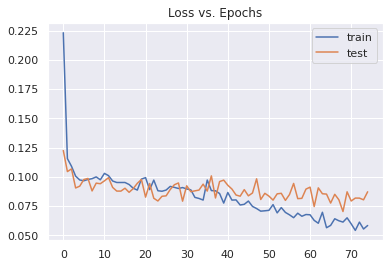

In [0]:
import keras
from keras import Sequential
from keras.regularizers import l1_l2, l2
from keras.layers import LSTM, Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[1], 
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
opt = Adam(lr=.005, clipnorm=.001)
model.compile(loss='mae', optimizer=opt)
# fit network
history = model.fit(X_train, y_train, epochs=75, batch_size=5, validation_data=(X_val, y_val), verbose=2, shuffle=True)
# plot history
plt.title('Loss vs. Epochs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

def revert_scaling(scale_df, name, vec):
  return vec * (scale_df[name].max() - scale_df[name].min()) + scale_df[name].min()

# calculate RMSE
yhat = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_test), revert_scaling(subset, 'specific_attention', yhat)))
print('Test RMSE: %.3f' % rmse)

yhat = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_val), revert_scaling(subset, 'specific_attention', yhat)))
print('Val RMSE: %.3f' % rmse)

yhat = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_train), revert_scaling(subset, 'specific_attention', yhat)))
print('Train RMSE: %.3f' % rmse)

Test RMSE: 14.116
Val RMSE: 10.189
Train RMSE: 7.317


In [0]:
# Trying the top of the responses list (more common sequences) 
X, y = responses[0:100, :, :-1], responses[0:100, :, -1]
print( "example sequence of input vectors corresponding to 10 responses by a particular student")
print(X.shape)
print("example test output of the RNN model")
print(y.shape)

example sequence of input vectors corresponding to 10 responses by a particular student
(100, 10, 4)
example test output of the RNN model
(100, 10)


In [0]:
# 80% train test split
train_pct = 0.8 
msk = np.random.rand(len(X)) < train_pct 
X_train, X_test = X[msk], X[~msk]
y_train, y_test = y[msk], y[~msk]


val_pct = 0.8 
msk = np.random.rand(len(X_train)) < val_pct
X_train, X_val = X_train[msk], X_train[~msk]
y_train, y_val = y_train[msk], y_train[~msk]

Train on 66 samples, validate on 21 samples
Epoch 1/75
 - 1s - loss: 0.2374 - val_loss: 0.1905
Epoch 2/75
 - 0s - loss: 0.1256 - val_loss: 0.1601
Epoch 3/75
 - 0s - loss: 0.1186 - val_loss: 0.1611
Epoch 4/75
 - 0s - loss: 0.1232 - val_loss: 0.1714
Epoch 5/75
 - 0s - loss: 0.1237 - val_loss: 0.1577
Epoch 6/75
 - 0s - loss: 0.1128 - val_loss: 0.1572
Epoch 7/75
 - 0s - loss: 0.1118 - val_loss: 0.1544
Epoch 8/75
 - 0s - loss: 0.1124 - val_loss: 0.1536
Epoch 9/75
 - 0s - loss: 0.1114 - val_loss: 0.1592
Epoch 10/75
 - 0s - loss: 0.1160 - val_loss: 0.1533
Epoch 11/75
 - 0s - loss: 0.1145 - val_loss: 0.1587
Epoch 12/75
 - 0s - loss: 0.1121 - val_loss: 0.1543
Epoch 13/75
 - 0s - loss: 0.1119 - val_loss: 0.1543
Epoch 14/75
 - 0s - loss: 0.1115 - val_loss: 0.1563
Epoch 15/75
 - 0s - loss: 0.1114 - val_loss: 0.1606
Epoch 16/75
 - 0s - loss: 0.1125 - val_loss: 0.1575
Epoch 17/75
 - 0s - loss: 0.1113 - val_loss: 0.1516
Epoch 18/75
 - 0s - loss: 0.1145 - val_loss: 0.1526
Epoch 19/75
 - 0s - loss: 0.1

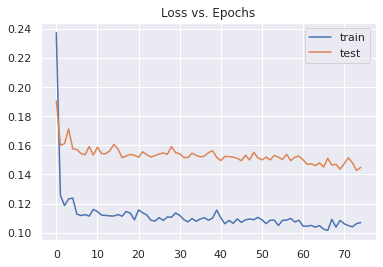

In [0]:
import keras
from keras import Sequential
from keras.regularizers import l1_l2, l2
from keras.layers import LSTM, Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[1], 
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
opt = Adam(lr=.005, clipnorm=.001)
model.compile(loss='mae', optimizer=opt)
# fit network
history = model.fit(X_train, y_train, epochs=75, batch_size=5, validation_data=(X_val, y_val), verbose=2, shuffle=True)
# plot history
plt.title('Loss vs. Epochs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

def revert_scaling(scale_df, name, vec):
  return vec * (scale_df[name].max() - scale_df[name].min()) + scale_df[name].min()

# calculate RMSE
yhat = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_test), revert_scaling(subset, 'specific_attention', yhat)))
print('Test RMSE: %.3f' % rmse)

yhat = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_val), revert_scaling(subset, 'specific_attention', yhat)))
print('Val RMSE: %.3f' % rmse)

yhat = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_train), revert_scaling(subset, 'specific_attention', yhat)))
print('Train RMSE: %.3f' % rmse)

Test RMSE: 13.637
Val RMSE: 16.091
Train RMSE: 12.624


## Shuffling the responses data

In [0]:
X, y = responses[:, :, :-1], responses[:, :, -1]
print( "example sequence of input vectors corresponding to 10 responses by a particular student")
print(X.shape)
print("example test output of the RNN model")
print(y.shape)

example sequence of input vectors corresponding to 10 responses by a particular student
(617, 10, 4)
example test output of the RNN model
(617, 10)


In [0]:
# 80% train test split
train_pct = 0.8 
msk = np.random.rand(len(X)) < train_pct 
X_train, X_test = X[msk], X[~msk]
y_train, y_test = y[msk], y[~msk]


val_pct = 0.8 
msk = np.random.rand(len(X_train)) < val_pct
X_train, X_val = X_train[msk], X_train[~msk]
y_train, y_val = y_train[msk], y_train[~msk]

Train on 395 samples, validate on 94 samples
Epoch 1/75
 - 1s - loss: 0.1708 - val_loss: 0.1267
Epoch 2/75
 - 1s - loss: 0.1453 - val_loss: 0.1292
Epoch 3/75
 - 1s - loss: 0.1392 - val_loss: 0.1205
Epoch 4/75
 - 1s - loss: 0.1385 - val_loss: 0.1204
Epoch 5/75
 - 1s - loss: 0.1364 - val_loss: 0.1199
Epoch 6/75
 - 1s - loss: 0.1361 - val_loss: 0.1186
Epoch 7/75
 - 1s - loss: 0.1370 - val_loss: 0.1184
Epoch 8/75
 - 1s - loss: 0.1369 - val_loss: 0.1202
Epoch 9/75
 - 1s - loss: 0.1361 - val_loss: 0.1224
Epoch 10/75
 - 1s - loss: 0.1372 - val_loss: 0.1312
Epoch 11/75
 - 1s - loss: 0.1361 - val_loss: 0.1171
Epoch 12/75
 - 1s - loss: 0.1354 - val_loss: 0.1169
Epoch 13/75
 - 1s - loss: 0.1347 - val_loss: 0.1172
Epoch 14/75
 - 1s - loss: 0.1340 - val_loss: 0.1166
Epoch 15/75
 - 1s - loss: 0.1350 - val_loss: 0.1148
Epoch 16/75
 - 1s - loss: 0.1336 - val_loss: 0.1174
Epoch 17/75
 - 1s - loss: 0.1341 - val_loss: 0.1183
Epoch 18/75
 - 1s - loss: 0.1346 - val_loss: 0.1160
Epoch 19/75
 - 1s - loss: 0.

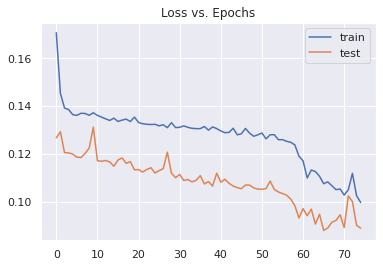

In [0]:
import keras
from keras import Sequential
from keras.regularizers import l1_l2, l2
from keras.layers import LSTM, Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[1], 
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
opt = Adam(lr=.005, clipnorm=.001)
model.compile(loss='mae', optimizer=opt)
# fit network
history = model.fit(X_train, y_train, epochs=75, batch_size=5, validation_data=(X_val, y_val), verbose=2, shuffle=True)
# plot history
plt.title('Loss vs. Epochs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

def revert_scaling(scale_df, name, vec):
  return vec * (scale_df[name].max() - scale_df[name].min()) + scale_df[name].min()

# calculate RMSE
yhat = model.predict(X_test)
print(X_test.shape)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_test), revert_scaling(subset, 'specific_attention', yhat)))
print('Test RMSE: %.3f' % rmse)

yhat = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_val), revert_scaling(subset, 'specific_attention', yhat)))
print('Val RMSE: %.3f' % rmse)

yhat = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(revert_scaling(subset, 'specific_attention', y_train), revert_scaling(subset, 'specific_attention', yhat)))
print('Train RMSE: %.3f' % rmse)

(128, 10, 4)
Test RMSE: 11.572
Val RMSE: 11.201
Train RMSE: 12.949


Using shuffled responses model on sequences with varying difficulties

In [0]:
# Manually looked at responses data for sequences with same difficult
# 616: difficult 5's
# 607: difficult 2
# 531: difficult 8's
# 233: difficult 1's

In [0]:
fives, att5 = responses[616:617, :, :-1], responses[616:617, :, -1]
twos, att2 = responses[607:608, :, :-1], responses[607:608, :, -1]
eights, att8 = responses[531:532, :, :-1], responses[531:532, :, -1]
ones, att1 = responses[233:234, :, :-1], responses[233:234, :, -1]

def caseTest(arr, att):
  yhat = model.predict(arr)
  print(arr[:,:,0])
  print('avg difficulty of sequence', np.mean(arr[:, :, 0]))
  print('avg predicted attention', np.mean(revert_scaling(subset, 'specific_attention', yhat)))
  print('avg reported attention', np.mean(revert_scaling(subset, 'specific_attention', att)))
  print()

caseTest(ones, att1)
caseTest(twos, att2)
caseTest(fives, att5)
caseTest(eights, att8)

# attention_fives = model.predict(fives)
# print(np.mean(fives[:, :, 0]))
# print("Predicted attention for difficulty level ~5: ")
# print(attention_fives*100)
# print("\n")

# attention_twos = model.predict(twos)
# print(np.mean(twos[:, :, 0]))
# print("Predicted attention for difficulty level ~2: ")
# print(attention_twos*100)
# print("\n")

# attention_eights = model.predict(eights)
# print(np.mean(eights[:, :, 0]))
# print("Predicted attention for difficulty level ~8: ")
# print(attention_eights*100)
# print("\n")

# attention_ones = model.predict(ones)
# print(np.mean(ones[:, :, 0]))
# print("Predicted attention for difficulty level ~1: ")
# print(attention_ones*100)
# print("\n")

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
avg difficulty of sequence 1.0
avg predicted attention 53.747894
avg reported attention 54.76851687711828

[[5. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
avg difficulty of sequence 2.3
avg predicted attention 34.8383
avg reported attention 50.34885187710033

[[5. 5. 5. 5. 5. 5. 5. 5. 5. 2.]]
avg difficulty of sequence 4.7
avg predicted attention 42.93207
avg reported attention 36.68126670052023

[[8. 5. 8. 8. 5. 8. 8. 5. 8. 8.]]
avg difficulty of sequence 7.1
avg predicted attention 67.9041
avg reported attention 67.19344105440027



This attention data is useful because curriculum designers can use this model on questions of similar difficulty to predict student's attention towards it. This can help formulate better curriculum targeted towards retaining students' attentions.

# Discussion

It seems like our model is usually off by around 14 attention points. This result is higher than the RMSE of around 10. achieved using the SVR classifier in aggregate (not including sequence information). Though this result is perhaps not what we expected to discover, we recognize that we faced many shortcomings when it came to our data consistency and therefore had to make certain assumptions when designing our LSTM model. As a result, we still believe that using a recurrent model is a good idea when predicting student attention across a sequence of problems and warrants additional research.

This model has still been trained on real 10-question data by students wearing attention-measurement gear. Instructors and curriculum creators can use a model like this and pass in relevant features about each question (difficulty, subject, expected student correctness, expected time spent on each problem) to determine how attentive students will be throughout an online assessment or lesson. This can help ensure that students stay engaged, a key challenge for MOOCs and online learning platforms in general.

Given some of the inconsistencies in our data and some of the assumptions we had to make in our methods, we highly encourage education data scientists to pursue more expansive and consistent data collection projects that make use of brainwave reading technology to better understand how the brain perceives information it's being taught. Maintaining attention and improving retention go hand-in-hand with learning. Further testing the hypothesis of our project could help education researchers identify the best ways to present content and maximize student assessments across the board moving forward.